# Transportation:  array-valued data and decisions

In [1]:
import pandas as pd
import numpy as np

import pyomo.environ as pe
import pyomo_helpers as helpers

%matplotlib inline

### Read and convert data

Let's make our lives easier and manipulate the spreadsheet to make it really easy to read the data in!

In [2]:
# Read in the data first, extracting on the parameters needed
cost = pd.read_excel('transportation-lp.xlsx', sheet_name='cost', index_col=0)
demand = pd.read_excel('transportation-lp.xlsx', sheet_name='demand', index_col=0)
capacity = pd.read_excel('transportation-lp.xlsx', sheet_name='capacity', index_col=0)

### Define model

Let's create two indexes called `plant` and `warehouse` and use them to define the decision variable `model.x`.

In [3]:
model = pe.AbstractModel()

num_warehouse = demand.shape[0]
num_plant = capacity.shape[0]

model.warehouse_i = pe.RangeSet(1, num_warehouse)
model.plant_i = pe.RangeSet(1, num_plant)

model.x = pe.Var(model.plant_i, model.warehouse_i, domain=pe.NonNegativeReals)

Next we'll use the `helpers` functions to create dictionaries that Pyomo can use for the parameters.

In [4]:
# Create the dictionaries
cost_dict = helpers.convert_2d_array_to_dict(cost)
demand_dict = helpers.convert_1d_array_to_dict(demand)
capacity_dict = helpers.convert_1d_array_to_dict(capacity)

# Create the model parameter objects
model.cost = pe.Param(model.plant_i, model.warehouse_i, initialize=cost_dict)
model.demand = pe.Param(model.warehouse_i, initialize=demand_dict)
model.capacity = pe.Param(model.plant_i, initialize=capacity_dict)

Our constraints here do not involve sumproducts, but rather row and column sums.  

In [5]:
def capacity_rule(model, plant):
    return sum(model.x[plant, wh] for wh in model.warehouse_i) <= model.capacity[plant]
model.capacity_cons = pe.Constraint(model.plant_i, rule=capacity_rule)

def demand_rule(model, wh):
    return sum(model.x[plant, wh] for plant in model.plant_i) >= model.demand[wh]
model.demand_cons = pe.Constraint(model.warehouse_i, rule=demand_rule)

Finally, our objective is a sumproduct over ALL decisions and costs.

In [6]:
def total_cost_rule(model):
    return sum(model.x[plant, wh] * model.cost[plant, wh]
                  for plant in model.plant_i
                      for wh in model.warehouse_i)
model.obj = pe.Objective(rule=total_cost_rule)

### Solve and analyze

In [7]:
instance, obj, solution = helpers.solve(model)


Problem: 
- Name: unknown
  Lower bound: 13830.0
  Upper bound: 13830.0
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 13
  Number of nonzeros: 25
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03121495246887207
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [9]:
# This is how you get the objective... here "obj" is what you named the objective object
# when you created the model.
print('total cost = {}'.format(obj))

total cost = 13830.0


In [10]:
# The dataframe is stored as a single column (i.e., a flattened array),
# but we want to display it as an array like in the spreadsheet.
solution.shape

(12, 1)

In [11]:
# Here is an example of how to reshape it into an array and give it appropriate row/col labels.
solution = pd.DataFrame(solution.values.reshape(num_plant, num_warehouse),
                        index=cost.index, 
                        columns=cost.columns)
solution.shape

(3, 4)

In [12]:
solution

,ATL,BOS,CHI,DEN
MIN,0.0,0.0,10000.0,0.0
PIT,5000.0,10000.0,0.0,0.0
TUC,3000.0,0.0,2000.0,9000.0


Let's visualize the solution with a heatmap from the seaborn package.

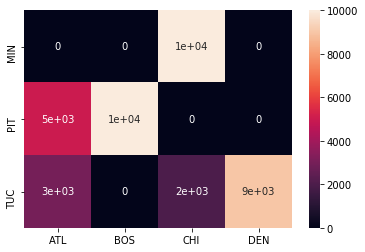

In [13]:
import seaborn as sns

_ = sns.heatmap(solution, annot=True)